In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
from imutils import paths
import tensorflow as tf

In [80]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_classifier_nn(image_size, class_num):
    input_shape = (image_size, image_size, 3)
    input_image = Input(shape=input_shape)
    # 1st Conv layer
    model = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape)(input_image)
    model = MaxPooling2D((2, 2),padding='same')(model)
    # 2nd Conv layer
    model = Conv2D(32, (3, 3), activation='relu', padding='same')(model)
    model = MaxPooling2D((2, 2),padding='same')(model)
    #model = Dropout(0.1)(model)
    # 3rd Conv layer
    model = Conv2D(64, (3, 3), activation='relu', padding='same')(model)
    model = MaxPooling2D((2, 2),padding='same')(model)
    # 4th Conv layer
    model = Conv2D(128, (3, 3), activation='relu', padding='same')(model)
    model = MaxPooling2D((2, 2),padding='same')(model)
    # 5th Conv layer
    model = Conv2D(256, (3, 3), activation='relu', padding='same')(model)
    model = MaxPooling2D((2, 2),padding='same')(model)
    # FC layers
    model = Flatten()(model)
    #model = Dense(1024, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(model)
    model = Dense(1024)(model)
    #model = Dropout(0.2)(model)

    #model = Dense(64, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(model)
    model = Dense(64)(model)
    #model = Dropout(0.2)(model)

    output= Dense(class_num, activation='softmax')(model)
    return Model(inputs=[input_image], outputs=[output])

def build_checkpointer(model_name, checkpoints_folder):
    return [
        EarlyStopping(
            monitor='val_accuracy',
            verbose=1,
            restore_best_weights=True,
            mode="max", 
            patience = 10
        ),
        ModelCheckpoint(
            filepath=f'{checkpoints_folder}/{model_name}'+'{epoch}.hdf5',
            monitor="val_accuracy",
            verbose=1,
            mode="max"
        )
    ]

In [50]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

def create_dataset(labels, labels_folders, image_size):
    data = []
    labels_names=[]
    for i, folder in enumerate(labels_folders):
        image_paths = list(paths.list_images(folder))
        labels_names += [labels[i]] * len(image_paths)
        for path in image_paths:
            image = load_img(path, target_size=(image_size, image_size))
            image = img_to_array(image)
            image = preprocess_input(image)
            data.append(image)
    data = np.array(data, dtype='float32')
    labels_names = np.array(labels_names)
    return data, labels_names

In [265]:
def plot_losses(history, title, figsize=(12, 7), output_file=None):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(1, len(loss_train) + 1)
    plt.figure(figsize=figsize)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if output_file is not None:
        plt.savefig(output_file)
    plt.show()
        
def plot_accuracy(history, title, figsize=(12, 7), output_file=None):
    acc_train = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    epochs = range(1, len(acc_train) + 1)
    plt.figure(figsize=figsize)
    plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    if output_file is not None:
        plt.savefig(output_file)
    plt.show()
        
def plot_accuracy_and_loss(history, title, figsize=(12, 7), output_file=None):
    pd.DataFrame(history.history).plot(figsize=figsize)
    plt.xlabel('Epochs')
    plt.title(title)
    if output_file is not None:
        plt.savefig(output_file)
    plt.show()

In [280]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, data_X, data_Y, lb, output_file=None):
    predict=model.predict(data_X, batch_size=32)
    predict=lb.inverse_transform(predict)
    expected = lb.inverse_transform(data_Y)
    matrix = confusion_matrix(expected, predict, labels=lb.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                                  display_labels=lb.classes_)
    disp.plot()
    #plt.show()
    if output_file is not None:
        plt.savefig(output_file, bbox_inches="tight")

## Training classifier neural network

In [253]:
data, labels = create_dataset(["mask_weared_incorrect",
                               "without_mask", 
                               "with_mask"],
                              ["data/Faces/mask_weared_incorrect",
                               "data/Faces/without_mask/",
                               "data/Faces/with_mask/"],
                              96)

In [254]:
data.shape

(8982, 96, 96, 3)

In [255]:
from sklearn.preprocessing import LabelBinarizer
from pickle import dump

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

dump(lb, open('models/Test/label-binarizer-mask_classifier-3-Faces.pkl', 'wb'))

In [256]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,width_shift_range=0.2,
    height_shift_range=0.2,shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [257]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report

train_X, test_X, train_Y, test_Y = train_test_split(
    data,
    labels,
    test_size=0.20,
    random_state=10,
    stratify=labels
)

In [258]:
model = build_classifier_nn(96, 3)
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_217 (Conv2D)         (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_117 (MaxPooli  (None, 48, 48, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_218 (Conv2D)         (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_118 (MaxPooli  (None, 24, 24, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_219 (Conv2D)         (None, 24, 24, 64)        184

In [259]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer="adam",
    metrics=['accuracy']
)

In [260]:
epochs = 30
batch_size = 32

In [261]:
history=model.fit(
    aug.flow(train_X, train_Y, batch_size=batch_size),
    validation_data=(test_X, test_Y),
    epochs=epochs,
    steps_per_epoch=len(train_X) // batch_size,
    callbacks=[build_checkpointer(f"mask_classifier_nn-96-96-Faces-{epochs}-", "models/Test/")]
)

Epoch 1/30
224/224 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.7534
Epoch 1: saving model to models/Test\mask_classifier_nn-96-96-Faces-30-1.hdf5
224/224 [==============================] - 101s 439ms/step - loss: 0.5922 - accuracy: 0.7534 - val_loss: 0.4492 - val_accuracy: 0.8253
Epoch 2/30
224/224 [==============================] - ETA: 0s - loss: 0.4490 - accuracy: 0.8301
Epoch 2: saving model to models/Test\mask_classifier_nn-96-96-Faces-30-2.hdf5
224/224 [==============================] - 86s 386ms/step - loss: 0.4490 - accuracy: 0.8301 - val_loss: 0.3752 - val_accuracy: 0.8481
Epoch 3/30
224/224 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.8714
Epoch 3: saving model to models/Test\mask_classifier_nn-96-96-Faces-30-3.hdf5
224/224 [==============================] - 89s 397ms/step - loss: 0.3555 - accuracy: 0.8714 - val_loss: 0.2510 - val_accuracy: 0.9037
Epoch 4/30
224/224 [==============================] - ETA: 0s - loss: 0.292

224/224 [==============================] - 86s 385ms/step - loss: 0.0872 - accuracy: 0.9720 - val_loss: 0.0647 - val_accuracy: 0.9811
Epoch 28/30
224/224 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.9739
Epoch 28: saving model to models/Test\mask_classifier_nn-96-96-Faces-30-28.hdf5
224/224 [==============================] - 85s 379ms/step - loss: 0.0768 - accuracy: 0.9739 - val_loss: 0.0734 - val_accuracy: 0.9772
Epoch 29/30
224/224 [==============================] - ETA: 0s - loss: 0.0897 - accuracy: 0.9695Restoring model weights from the end of the best epoch: 19.

Epoch 29: saving model to models/Test\mask_classifier_nn-96-96-Faces-30-29.hdf5
224/224 [==============================] - 86s 383ms/step - loss: 0.0897 - accuracy: 0.9695 - val_loss: 0.0586 - val_accuracy: 0.9816
Epoch 29: early stopping


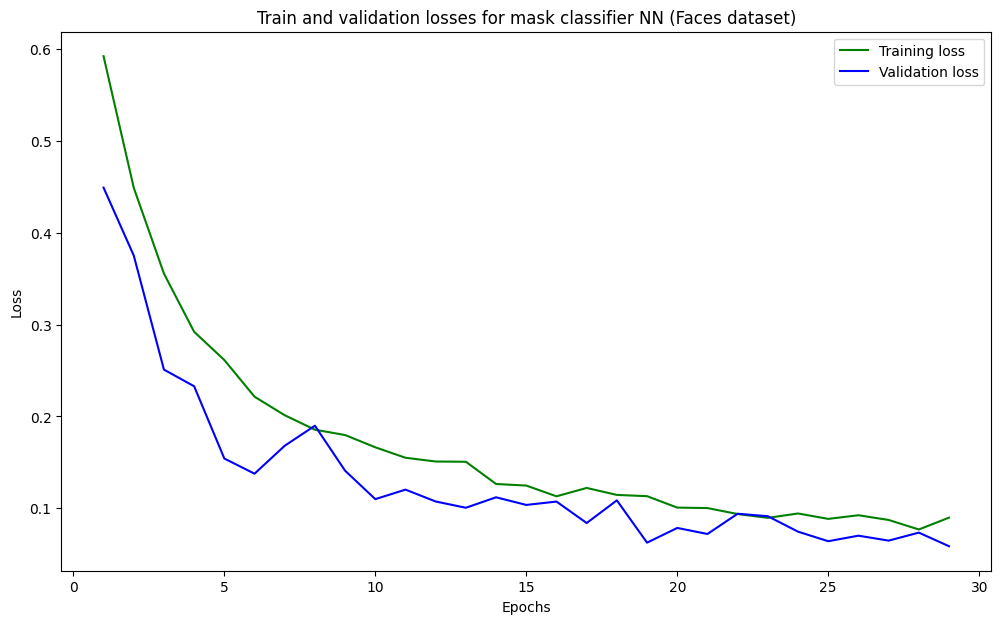

In [268]:
plot_losses(history, 
            "Train and validation losses for mask classifier NN (Faces dataset)",
            output_file="images/losses-mask_classifier-Faces.jpeg"
)

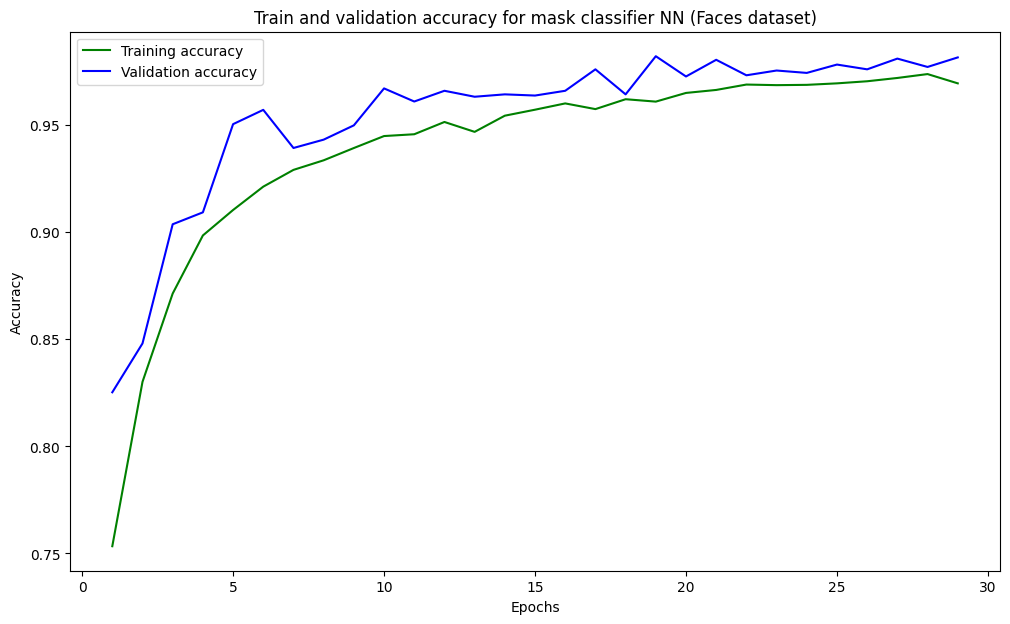

In [274]:
plot_accuracy(
    history,
    "Train and validation accuracy for mask classifier NN (Faces dataset)",
     output_file="images/accuracy-mask_classifier-Faces.svg"
)

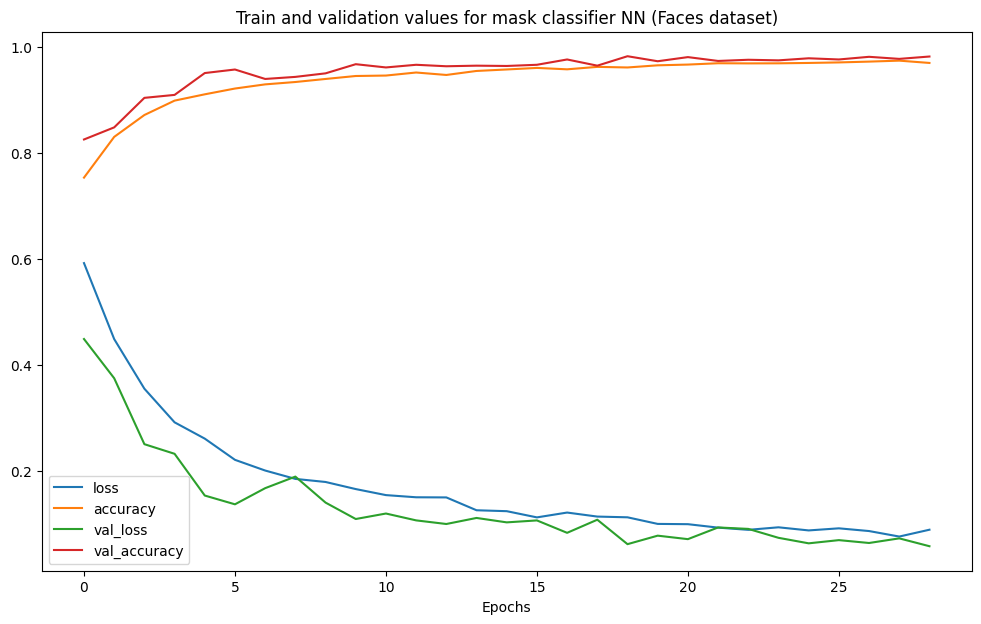

In [277]:
plot_accuracy_and_loss(
    history,
    "Train and validation values for mask classifier NN (Faces dataset)",
    output_file="images/accuracy-losses-mask_classifier-Faces.svg"
)

57/57 [==============================] - 5s 83ms/step


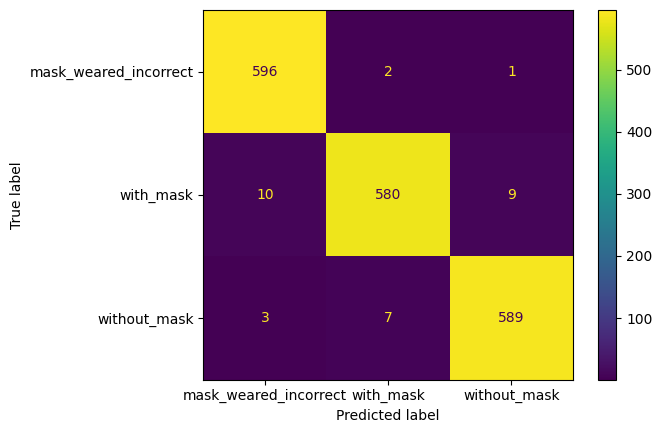

In [283]:
plot_confusion_matrix(
    model,
    test_X,
    test_Y,
    lb,
    output_file="images/confusion_matrix-mask_classifier-Faces.png"
)

## Training face detector NN

### Creating the dataset

In [285]:
import xml.etree.ElementTree as ET

classes = {"with_mask": 0, "without_mask": 1, "mask_weared_incorrect": 2}
def get_objects(filepath, classes=classes):
    parser = ET.XMLParser(encoding="utf-8")
    targetTree = ET.parse(filepath, parser=parser)
    rootTag = targetTree.getroot()
    res = np.array([[0] * 5])
    for obj in rootTag.findall("object"):
        label_name = obj.find("name").text
        bndbox = obj.find("bndbox")
        res = np.append(
            res,
            np.array([
                [int(bndbox.find("xmin").text),
                 int(bndbox.find("ymin").text),
                 int(bndbox.find("xmax").text),
                 int(bndbox.find("ymax").text),
                 classes[label_name]]
            ]), 
            axis=0)
    return res[1:]


In [289]:
background_images = []

image_folder = "data/HumanPhotos/train/"
annotations_folder = "data/HumanPhotos/annotations/"

photos_and_objects = []

for name in os.listdir(image_folder):
    if "png" not in name:
        continue
    image = cv2.imread(image_folder + name)
    objects = np.array([obj[:4] for obj in
                        get_objects(annotations_folder + name.replace("png", "xml"))])
    photos_and_objects.append((image, objects))


print(len(photos_and_objects)) 

599


In [303]:
face_count = 0
for photo, objects in photos_and_objects:
    for obj in objects:
        face = photo[obj[1]: obj[3], obj[0]: obj[2]]
        cv2.imwrite(f"data/FacesDetectionGenerated/Face/{face_count}.png", face)
        face_count += 1
face_count

2917

In [304]:
import random

width = (32, 128)
height = (32, 128)

no_face_count = 0
while no_face_count < face_count:
    index = random.randint(0, len(photos_and_objects) - 1)
    image, objects = photos_and_objects[index]
    if image is None:
        continue
    shape_y, shape_x, _ = image.shape
    rand_width = random.randint(*width)
    rand_height = random.randint(*height)
    x = random.randint(0, shape_x - rand_width - 1)
    y = random.randint(0, shape_y - rand_height - 1)
    
    overlapping = False
    for obj in objects:
        if (x + rand_width < obj[0] or x > obj[2] or y + rand_height < obj[1] or y > obj[3]):
            continue
        overlapping = True
        break
            
    if overlapping:
        continue
    cropped = image[y: y + rand_height, x: x + rand_width]
    no_face_count += 1
    cv2.imwrite(f"data/FacesDetectionGenerated/No_Face/{no_face_count}.png", cropped)
    
no_face_count

2917

### Creating the model

In [312]:
from tensorflow.keras.layers import Dropout, BatchNormalization

def build_simple_classifier_nn(image_size, class_num):
    input_shape = (image_size, image_size, 3)
    input_image = Input(shape=input_shape)
    # 1st Conv layer
    model = Conv2D(64, (2, 2), activation='relu', padding='same', input_shape=input_shape)(input_image)
    model = MaxPooling2D((4, 4),padding='same')(model)
    # 2nd Conv layer
    model = Conv2D(128, (2, 2), activation='relu', padding='same')(model)
    model = MaxPooling2D((4, 4),padding='same')(model)
    model = BatchNormalization()(model)
    # FC layers
    model = Flatten()(model)
    model = Dense(128)(model)
    model = Dropout(0.1)(model)

    output= Dense(class_num, activation='softmax')(model)
    return Model(inputs=[input_image], outputs=[output])


Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_236 (Conv2D)         (None, 64, 64, 64)        832       
                                                                 
 max_pooling2d_136 (MaxPooli  (None, 16, 16, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_237 (Conv2D)         (None, 16, 16, 128)       32896     
                                                                 
 max_pooling2d_137 (MaxPooli  (None, 4, 4, 128)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_2 (Batc  (None, 4, 4, 128)        512

In [387]:
data, labels = create_dataset(["face",
                               "no_face"],
                              ["data/FacesDetectionGenerated/Face/",
                               "data/FacesDetectionGenerated/No_Face/"],
                              64)

In [388]:
data.shape

(5835, 64, 64, 3)

In [389]:
from tensorflow.keras.utils import to_categorical
lb = LabelBinarizer()

labels = lb.fit_transform(labels)
labels = to_categorical(labels)
dump(lb, open('models/Test/label-binarizer-face_detector-2-Generated.pkl', 'wb'))

In [390]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [391]:
train_X, test_X, train_Y, test_Y = train_test_split(
    data,
    labels,
    test_size=0.20,
    random_state=10,
    stratify=labels
)

In [392]:
model = build_simple_classifier_nn(64, 2)
model.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_254 (Conv2D)         (None, 64, 64, 64)        832       
                                                                 
 max_pooling2d_154 (MaxPooli  (None, 16, 16, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_255 (Conv2D)         (None, 16, 16, 128)       32896     
                                                                 
 max_pooling2d_155 (MaxPooli  (None, 4, 4, 128)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_6 (Batc  (None, 4, 4, 128)        512

In [393]:
model.compile(
    loss='categorical_crossentropy',
    optimizer="sgd",
    metrics=['accuracy']
)

In [394]:
epochs = 30
batch_size = 32

In [395]:
history=model.fit(
    aug.flow(train_X, train_Y, batch_size=batch_size),
    validation_data=(test_X, test_Y),
    epochs=epochs,
    steps_per_epoch=len(train_X) // batch_size,
    callbacks=[build_checkpointer(f"face_detector_nn-64-64-Generated-{epochs}-", "models/Test/")]
)

Epoch 1/30
145/145 [==============================] - ETA: 0s - loss: 0.4821 - accuracy: 0.7975
Epoch 1: saving model to models/Test\face_detector_nn-64-64-Generated-30-1.hdf5
145/145 [==============================] - 36s 238ms/step - loss: 0.4821 - accuracy: 0.7975 - val_loss: 0.5004 - val_accuracy: 0.8989
Epoch 2/30
145/145 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.8678
Epoch 2: saving model to models/Test\face_detector_nn-64-64-Generated-30-2.hdf5
145/145 [==============================] - 23s 156ms/step - loss: 0.3135 - accuracy: 0.8678 - val_loss: 0.3564 - val_accuracy: 0.9126
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.8898
Epoch 3: saving model to models/Test\face_detector_nn-64-64-Generated-30-3.hdf5
145/145 [==============================] - 21s 147ms/step - loss: 0.2648 - accuracy: 0.8898 - val_loss: 0.2593 - val_accuracy: 0.9075
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 

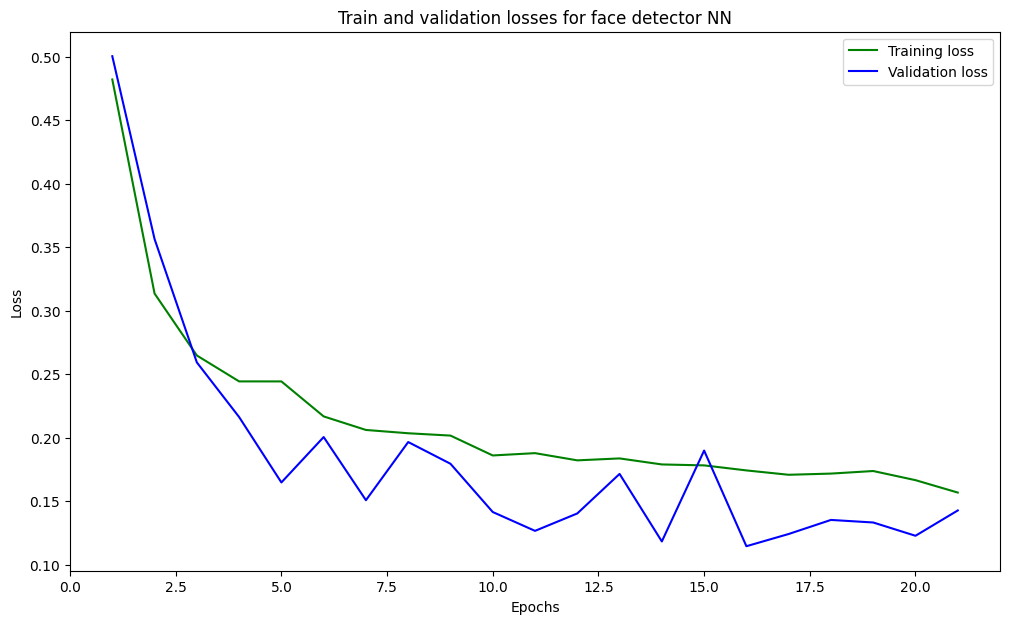

In [398]:
plot_losses(
    history,
    "Train and validation losses for face detector NN",
    output_file="images/losses-face_detector.jpeg"
)

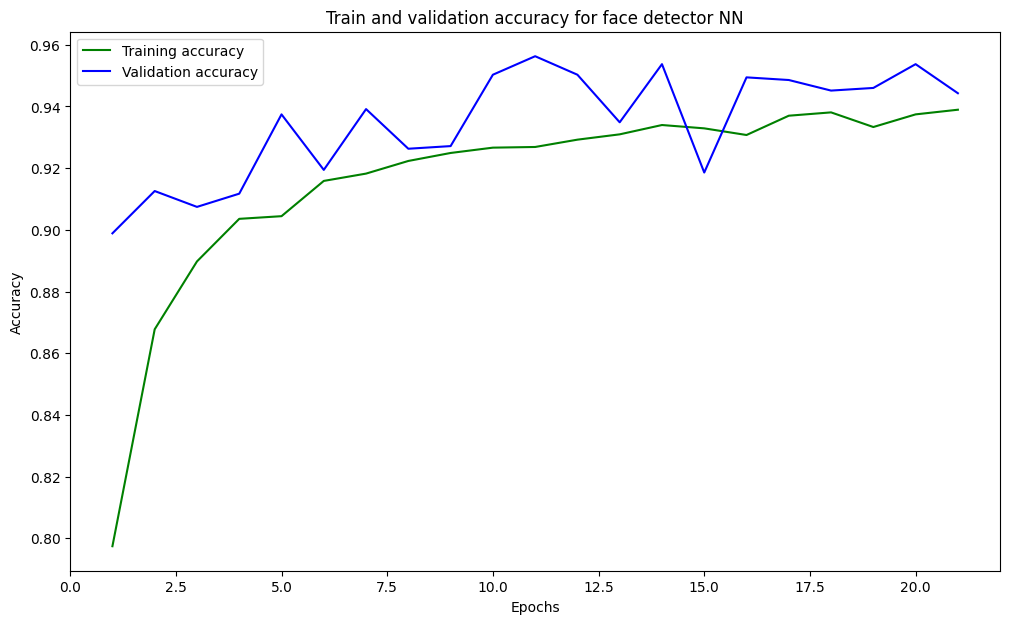

In [401]:
plot_accuracy(
    history,
    "Train and validation accuracy for face detector NN",
    output_file="images/accuracy-face_detector.svg"
)

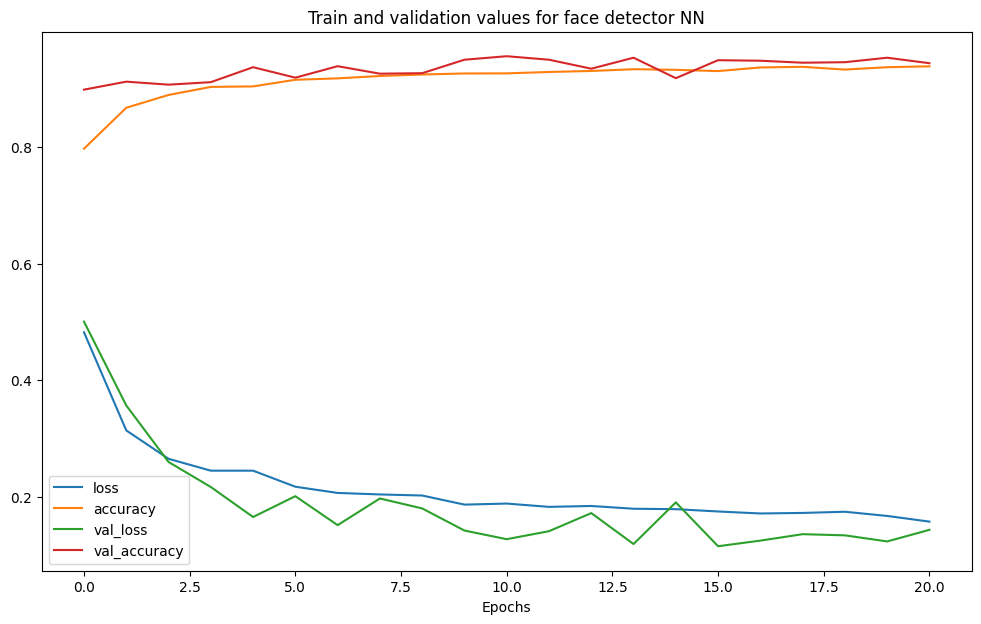

In [404]:
plot_accuracy_and_loss(
    history,
    "Train and validation values for face detector NN",
    output_file="images/accuracy-losses-face_detector.svg"
)

37/37 [==============================] - 1s 35ms/step


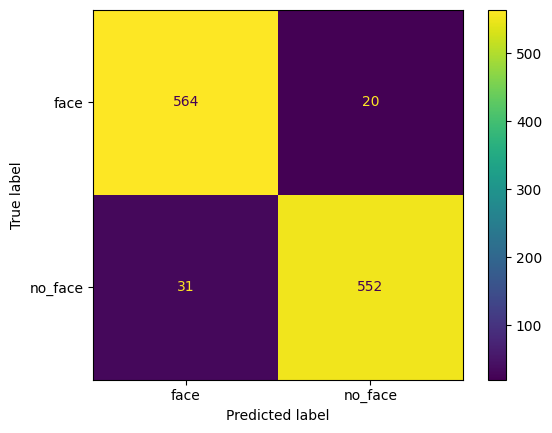

In [407]:
plot_confusion_matrix(
    model,
    test_X,
    test_Y,
    lb,
    output_file="images/confusion_matrix-face_detector.svg")

In [359]:
data, labels = create_dataset(["mask_weared_incorrect",
                               "without_mask",
                               "with_mask"],
                              ["data/FMD_DATASET/incorrect_mask/",
                               "data/FMD_DATASET/without_mask/",
                               "data/FMD_DATASET/with_mask/"],
                              96)

c:\users\sonia\desktop\facemask_detection\test\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [361]:
data.shape

(14536, 96, 96, 3)

In [362]:
from tensorflow.keras.utils import to_categorical
lb = LabelBinarizer()

labels = lb.fit_transform(labels)
dump(lb, open('models/Test/label-binarizer-mask_classifier-3-FMD.pkl', 'wb'))

In [363]:
train_X, test_X, train_Y, test_Y = train_test_split(
    data,
    labels,
    test_size=0.20,
    random_state=10,
    stratify=labels
)

In [370]:
model = build_classifier_nn(96, 3)
model.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_249 (Conv2D)         (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_149 (MaxPooli  (None, 48, 48, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_250 (Conv2D)         (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_150 (MaxPooli  (None, 24, 24, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_251 (Conv2D)         (None, 24, 24, 64)        184

In [371]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer="adam",
    metrics=['accuracy']
)

In [372]:
epochs = 30
batch_size = 32

In [373]:
# computing weights
classes_counts = {elem: 0 for elem in lb.classes_}
for elem in lb.inverse_transform(labels):
    classes_counts[elem] = classes_counts.get(elem, 0) + 1
classes_weights = {i: len(labels)/val for i, val in enumerate(classes_counts.values())}
classes_weights

{0: 2.9072, 1: 3.0352892044268116, 2: 3.062144512323573}

In [374]:
history = model.fit(
    aug.flow(train_X, train_Y, batch_size=batch_size),
    validation_data=(test_X, test_Y),
    epochs=epochs,
    steps_per_epoch=len(train_X) // batch_size,
    class_weight=classes_weights,
    callbacks=[build_checkpointer(f"mask_classifier_nn-96-96-FMD-{epochs}-", "models/Test/")]
)

Epoch 1/30
363/363 [==============================] - ETA: 0s - loss: 1.3985 - accuracy: 0.8036
Epoch 1: saving model to models/Test\mask_classifier_nn-96-96-FMD-30-1.hdf5
363/363 [==============================] - 150s 408ms/step - loss: 1.3985 - accuracy: 0.8036 - val_loss: 0.2426 - val_accuracy: 0.9120
Epoch 2/30
363/363 [==============================] - ETA: 0s - loss: 0.7567 - accuracy: 0.9101
Epoch 2: saving model to models/Test\mask_classifier_nn-96-96-FMD-30-2.hdf5
363/363 [==============================] - 149s 410ms/step - loss: 0.7567 - accuracy: 0.9101 - val_loss: 0.2066 - val_accuracy: 0.9298
Epoch 3/30
363/363 [==============================] - ETA: 0s - loss: 0.6276 - accuracy: 0.9250
Epoch 3: saving model to models/Test\mask_classifier_nn-96-96-FMD-30-3.hdf5
363/363 [==============================] - 150s 413ms/step - loss: 0.6276 - accuracy: 0.9250 - val_loss: 0.2110 - val_accuracy: 0.9216
Epoch 4/30
363/363 [==============================] - ETA: 0s - loss: 0.5826 - 

363/363 [==============================] - 147s 405ms/step - loss: 0.3074 - accuracy: 0.9636 - val_loss: 0.1010 - val_accuracy: 0.9687
Epoch 28/30
363/363 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.9651
Epoch 28: saving model to models/Test\mask_classifier_nn-96-96-FMD-30-28.hdf5
363/363 [==============================] - 146s 402ms/step - loss: 0.3056 - accuracy: 0.9651 - val_loss: 0.1077 - val_accuracy: 0.9660
Epoch 29/30
363/363 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.9654
Epoch 29: saving model to models/Test\mask_classifier_nn-96-96-FMD-30-29.hdf5
363/363 [==============================] - 147s 405ms/step - loss: 0.2846 - accuracy: 0.9654 - val_loss: 0.1290 - val_accuracy: 0.9580
Epoch 30/30
363/363 [==============================] - ETA: 0s - loss: 0.2883 - accuracy: 0.9658
Epoch 30: saving model to models/Test\mask_classifier_nn-96-96-FMD-30-30.hdf5
363/363 [==============================] - 147s 404ms/step - loss: 0.2

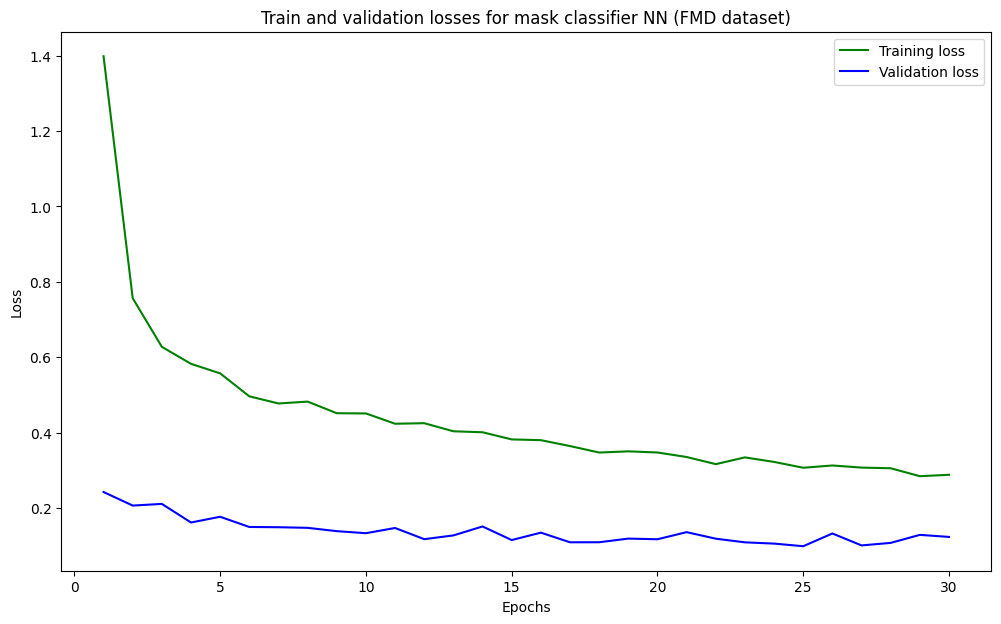

In [380]:
plot_losses(history, 
            "Train and validation losses for mask classifier NN (FMD dataset)",
            output_file="images/losses-mask_classifier-FMD.svg"
)

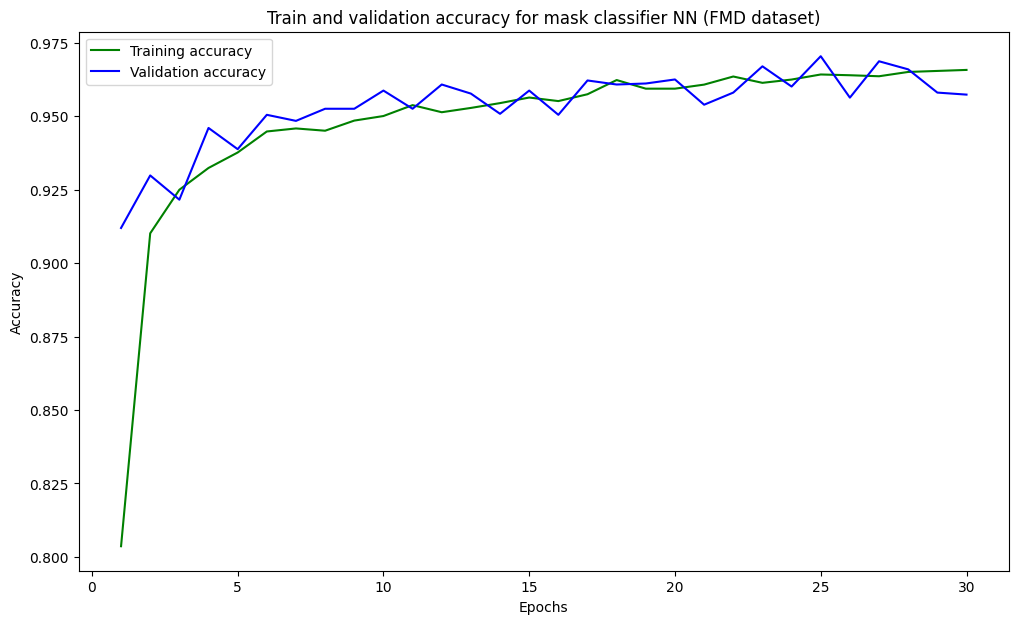

In [382]:
plot_accuracy(
    history,
    "Train and validation accuracy for mask classifier NN (FMD dataset)",
     output_file="images/accuracy-mask_classifier-FMD.jpeg"
)

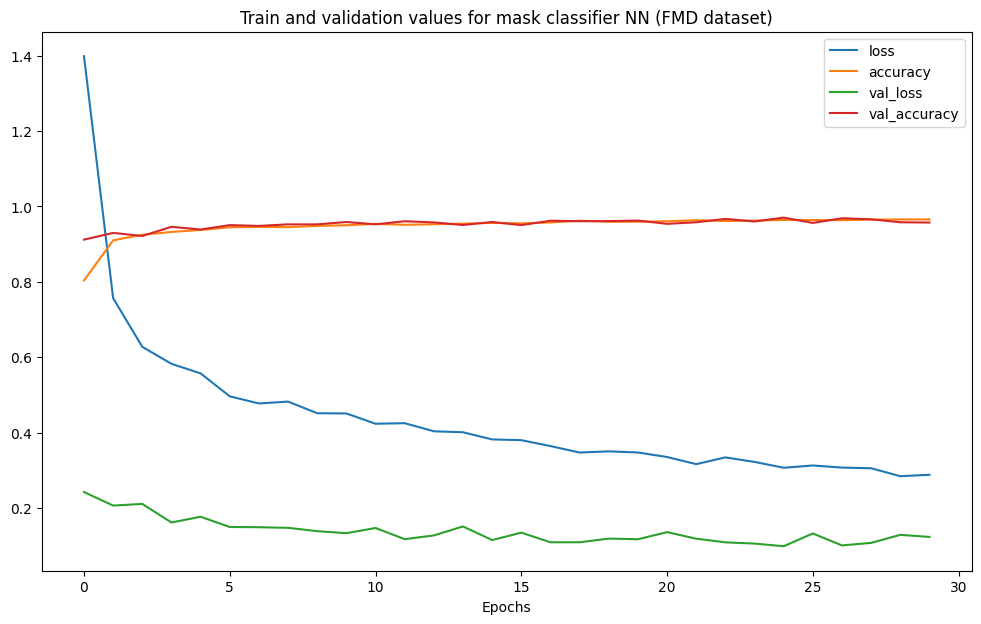

In [384]:
plot_accuracy_and_loss(
    history,
    "Train and validation values for mask classifier NN (FMD dataset)",
    output_file="images/accuracy-losses-mask_classifier-FMD.jpeg"
)

91/91 [==============================] - 8s 86ms/step


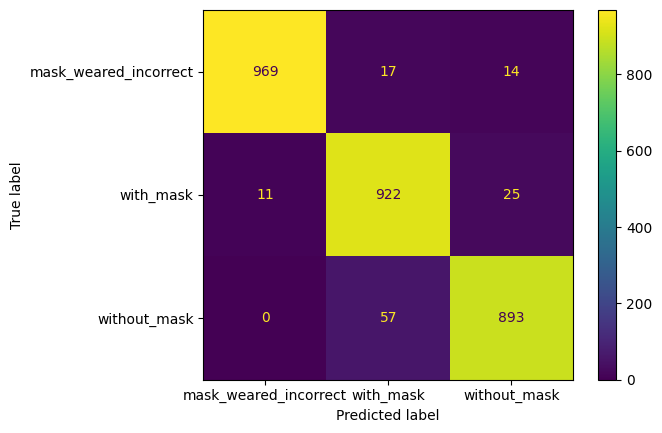

In [386]:
plot_confusion_matrix(
    model,
    test_X,
    test_Y,
    lb,
    output_file="images/confusion_matrix-mask_classifier-FMD.svg"
)